# Keypoint Detection using YOLO v7 #

In [1]:
import sys
import torch
import torchvision
import cv2
import yaml
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import os
sys.path.append("FishVision")

!nvidia-smi

Tue Mar 28 20:06:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:36:00.0 Off |                    0 |
| N/A   32C    P0    49W / 350W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# YOLO v7 setup

%cd /home/tanjan/FishVision/yolov7
%ls

from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

# testing YOLO setup with inference
#!python detect.py --weights yolov7.pt --source inference/images/horses.jpg --img 640

/home/tanjan/FishVision/yolov7
2022-04-11-00-01-10_right.jpg_7.png  models/               tools/
cfg/                                 new_dir/              traced_model.pt
data/                                paper/                train_aux.py
deploy/                              Pontatal-86klein.jpg  train.py
detect.py                            __pycache__/          utils/
export.py                            README.md             yolov7.pt
figure/                              requirements.txt      yolov7-w6-person.pt
hubconf.py                           runs/                 yolov7-w6-pose.pt
inference/                           scripts/
LICENSE.md                           test.py


## Testing for human keypoint detection with pretrained model and weights ##

In [3]:
# initialize for CUDA with pretrained pose estimation weights for human model test

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

In [4]:
testimage = 'Pontatal-86klein.jpg'

image = cv2.imread(testimage)
image = letterbox(image, 960, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))

if torch.cuda.is_available():
    image = image.half().to(device)   
output, _ = model(image)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:599: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2299.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
with torch.no_grad():
    output = output_to_keypoint(output)
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
for idx in range(output.shape[0]):
    plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

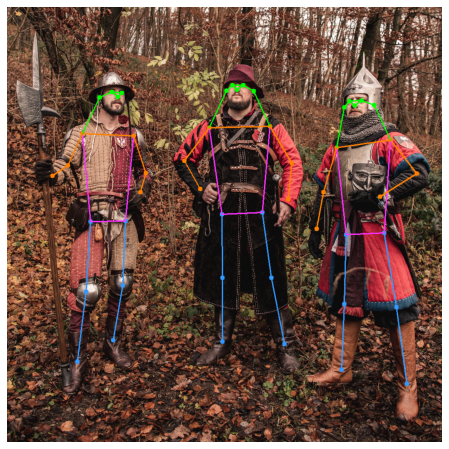

In [6]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(nimg)
plt.show()

## Application for Fish Keypoint Detection ##

* ensure that keypoints are in COCO annotation format
* split data into test/train
* transfer learning: keep model and weights of yolov7-w6-pose.pt and test on fish: nothing happens, no keypoints found
* new annotations
* adapt train.py to take in new keypoints and training data

In [ ]:
# keypoint conversion from COCO to YOLO v7 format
# converting the ultralytics JSON2YOLO converter at https://github.com/ultralytics/JSON2YOLO for additional keypoint data
# format: class, x_center, y_center, width, height, kpt1_x, kpt1_y, visibility_1, ..., kptn_x, kptn_y, visibility_n

import itertools
import general_JSON2YOLO as jtyo 
import importlib
importlib.reload(jtyo)

#jtyo.convert_coco_json('/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct', '/home/tanjan/FishVision/data')
# move labels to correct folder afterwards

# computed

In [3]:
# sort the images after the test/train split

import splitfolders

# Split with a ratio of .8 : .1 : .1 train:test:val
splitfolders.ratio('/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/', output='/home/tanjan/FishVision/data',
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) 

Copying files: 939 files [00:00, 1061.44 files/s]


In [ ]:
# implementation of weights and biases
# install and activate with "conda install -c conda-forge wandb" and "wandb login" with API key

import wandb

wandb.init(project='FishVision', entity='tnuendel')
'''
config = wandb.config
config.learning_rate = 0.01
config.momentum = 0.9
'''

# wandb.log({'epoch': epoch, 'loss': running_loss})

# initialize for CUDA with pretrained pose estimation weights for human model test

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

In [ ]:
# custom model training in simple CLI fashion
%cd /home/tanjan/FishVision/yolov7

!python train.py --workers 8 --device 0 --batch-size 8 --epochs 100 --img 512 --hyp data/hyp.scratch.custom.yaml --name yolov7-fish --weights yolov7-w6-pose.pt